Freq_domain_meas
=================

* **[Cavity search](#Cavity-search)** 
Search the location of the cavity with $sweeping$ $LO$ $frequency$ due to large frequency range (e.g. $5.0$ - $7.0$ GHz)

(Frequency range needs to be a `float` number

* **[Accurate Cavity search](#Accurate-Cavity-search)**
Search the location of the cavity with $sweeping$ $NCO$ $frequency$ due to small frequency range (e.g. $6.0$ - $6.04$ GHz)


* **[Power dependent cavity](#Power-dependent-cavity)** 
Search the location of the dress state cavity with $sweeping$ $NCO$ $frequency$ due to small frequency range (e.g. $6.0$ - $6.004$ GHz)

* **[Flux dependent cavity](#Flux-dependent-cavity)** 

* **[Two-tone](#Two-tone)** 


To run this, you will need:
* [QRM-RF](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/qcm_rf.html)
* Device under test: a Superconducting Qubit
* Two SMA-cables
* Installation and enabling of ipywidgets


Cluster Setup
-----

In [1]:
from aux import *
from numpy import arange, linspace
meas_datadir = './Data'
dh.set_datadir(meas_datadir)
# Connect to Cluster
warnings.simplefilter("ignore")
connect, ip = connect_clusters()



Dropdown(description='Select Device', options=(('Marketing-Cluster @192.168.1.170', '00015_2247_002'),), value…

In [85]:
Instrument.close_all()              # Close all existing QCoDeS Instrument instances
dev_id = connect.value
cluster = Cluster(name = "cluster0", identifier = ip.get(dev_id))
print(f"{connect.label} connected")

# Reset the cluster
cluster.reset()        
print(cluster.get_system_state())
# Hardware settings
hardware_cfg = {
    "backend": "quantify_scheduler.backends.qblox_backend.hardware_compile",
    "cluster0": {
        "sequence_to_file": False,  # Boolean flag which dumps waveforms and program dict to JSON file
        "ref": "internal",  # Use shared clock reference of the cluster
        "instrument_type": "Cluster",
        # ============ DRIVE ============#
        "cluster0_module4": {
            "instrument_type": "QCM_RF",
            "complex_output_0": {
                "output_att": 0,
                "dc_mixer_offset_I": 0.0,
                "dc_mixer_offset_Q": 0.0,
                "portclock_configs": [
                    {
                        "port": "qubit:mw",
                        "clock": "qubit.01",
                        "interm_freq": 80e6,
                        "mixer_amp_ratio": 1.0,
                        "mixer_phase_error_deg": 0.0,
                    }
                ],
            },
        },
        # ============ FLUX ============#
        "cluster0_module2": {
            "instrument_type": "QCM",
            "real_output_0": {"portclock_configs": [{"port": "qubit:fl", "clock": "cl0.baseband"}]},
        },
        # ============ READOUT ============#
        "cluster0_module8": {
            "instrument_type": "QRM_RF",
            "complex_output_0": {
                "output_att": 0,
                "input_att": 0,
                "dc_mixer_offset_I": 0.0,
                "dc_mixer_offset_Q": 0.0,
                "lo_freq": 5.7e9,       # *** Should be set as a parameter later on
                "portclock_configs": [
                    {
                        "port": "qubit:res",
                        "clock": "qubit.ro",
                        "mixer_amp_ratio": 1.0,
                        "mixer_phase_error_deg": 0.0,
                    }
                ],
            },
        },
    },
}

# quantum_device and qubit regiterations->TODO: defined as a function
qubit = BasicTransmonElement("qubit")
qubit.measure.acq_channel(8)

quantum_device = QuantumDevice("device_1q")
quantum_device.hardware_config(hardware_cfg) 
quantum_device.add_element(qubit)  # We always reset the cluster again, so the information about qubit will be dispose, then add again here.

meas_ctrl, instrument_coordinator = configure_measurement_control_loop(quantum_device, cluster)

# Flux bias setting
flux_settable: callable = cluster.module2.out0_offset
flux_settable(0.0)

# Activate NCO delay compensation
for i in range(6):
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp_en(True)
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp(50)

# Attenuation setting. We don't change it once we set it.
ro_out_att = 22
xy_out_att = 10
# atte. setting
set_readout_attenuation(quantum_device, qubit, out_att=ro_out_att, in_att=0)
set_drive_attenuation(quantum_device, qubit, out_att=xy_out_att)

Marketing-Cluster @192.168.1.170 connected
Status: OKAY, Flags: NONE, Slot flags: NONE


Accurate Cavity search
-------------

After fixing the approximate resonator frequencies, 
sweeping NCO frequency to get the location frequency of all cavities, 
the frequency you get will be the accurate $bare$ $state$ $frequency$.

This can also check the $dress$ $state$ $frequency$ by changing **ro_out_att** value.

spec_sched_kwargs
pulse_amp         = 0.1
pulse_duration    = 2e-06
frequencies       = freq
acquisition_delay = 8e-08
integration_time  = 1.5e-06
port              = qubit:res
clock             = qubit.ro
init_duration     = 1e-05
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 41



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

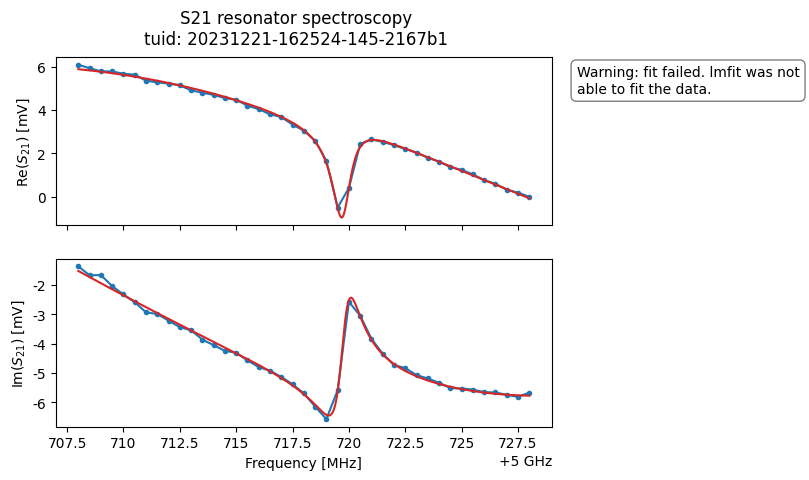

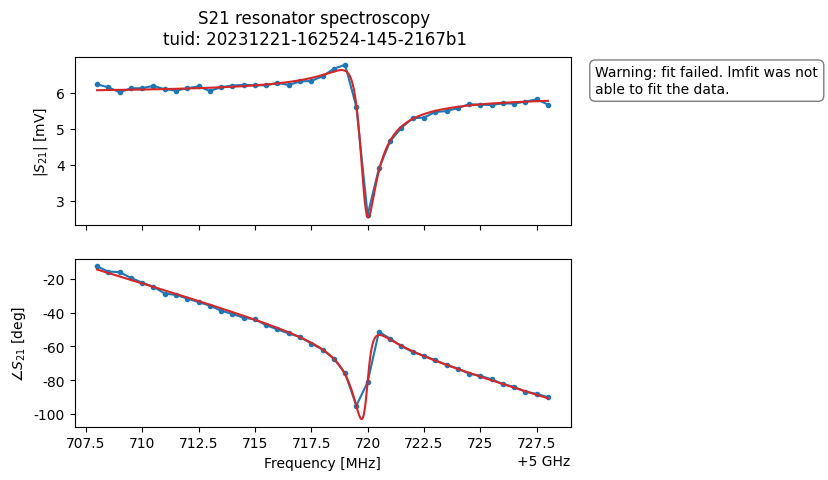

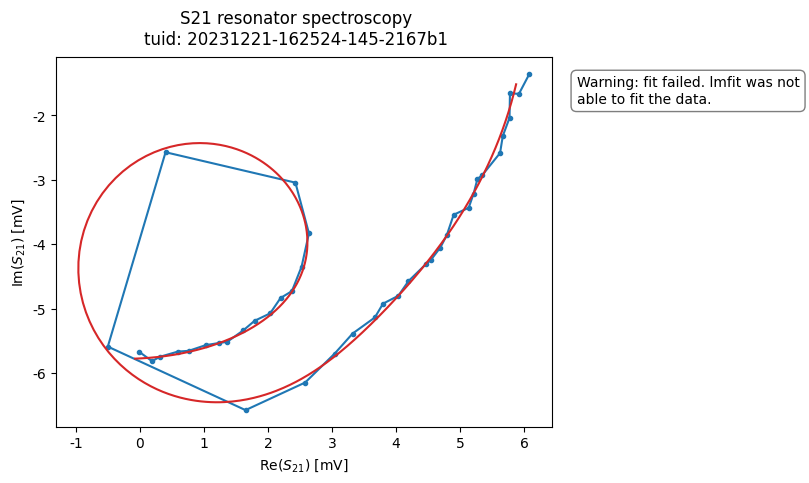

In [86]:

# ============= manually set Parameters =================
repeat_times = 1000
rof_center = 5.718e9  # Range ~40MHz
rof_span = 10e6
resolutions = 0.5e6
# =======================================================
rof_samples = arange(rof_center-rof_span,rof_center+rof_span+resolutions,resolutions)

# declare variables
freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True
freq.batch_size = 100

# requisition
spec_sched_kwargs = dict(    # *** Try to draw the prospective wave as a plot for a great check of the outputting pulse. And turn them into parameters
    pulse_amp=0.1,           # *** Check the unit of amplitude, only scale or volt # Can be set as a parameter
    pulse_duration=2e-6,     # *** Can be set as a parameter
    frequencies=freq,
    acquisition_delay=80e-9,# *** Can be set as a parameter
    integration_time=1.5e-6,   # *** Can be set as a parameter
    port=qubit.ports.readout(),
    clock=qubit.name + ".ro",
    init_duration=10e-6,     # *** Can be set as a parameter
)
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=heterodyne_spec_sched_nco,  # *** Def: https://quantify-os.org/docs/quantify-scheduler/dev/autoapi/quantify_scheduler/schedules/index.html
    schedule_kwargs=spec_sched_kwargs,
    real_imag=False,
    batched=True,
)
show_args(spec_sched_kwargs, title="spec_sched_kwargs")  # *** Try to insert this into interfaces

# send the requisition to MeasurementControl-er
quantum_device.cfg_sched_repetitions(repeat_times)
meas_ctrl.gettables(gettable)
meas_ctrl.settables(freq)
meas_ctrl.setpoints(rof_samples)

# MeasurementControl-er start measurement by the requisition
rs_ds = meas_ctrl.run("resonator spectroscopy")
rs_ds

# Analysis
rs_analysis = ResonatorSpectroscopyAnalysis(tuid=rs_ds.attrs["tuid"], dataset=rs_ds)
rs_analysis.run().display_figs_mpl()

# feedback
# bare freq = rs_analysis.quantities_of_interest['fr'].nominal_value

In [87]:
# fill up the spec for qubit like reset-time, ROL, ROW, ROF...
executor = True
if executor:
    qubit.reset.duration(100e-6)
    qubit.measure.acq_delay(spec_sched_kwargs["acquisition_delay"])
    qubit.measure.pulse_amp(spec_sched_kwargs["pulse_amp"])
    qubit.measure.pulse_duration(spec_sched_kwargs["pulse_duration"])
    qubit.measure.integration_time(spec_sched_kwargs["integration_time"])

    qubit.clock_freqs.readout(rs_analysis.quantities_of_interest["fr"].nominal_value)
    executor = False
# show_readout_args(qubit)

Power dependent cavity
------------------------

Sweeping NCO frequency to get the location dress state frequency of each cavity found in cavity search, with 2D plot we can get the $intensity$ $of$ $the$ $signal$ and $dress$ $state$ $frequency$

The Q1ASM sequencer program only supports integer values. However, the NCO has a frequency resolution of 0.25 Hz. As such, the frequency values in the sequencer program must be given as integer multiples of $1/4$ Hz.

spec_sched_kwargs
pulse_amp         = ro_pulse_amp
pulse_duration    = 2e-06
frequencies       = freq
acquisition_delay = 8e-08
integration_time  = 1.5e-06
init_duration     = 1e-05
port              = qubit:res
clock             = qubit.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 ro_pulse_amp 
Batched settable(s):
	 freq 
Batch size limit: 1024



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

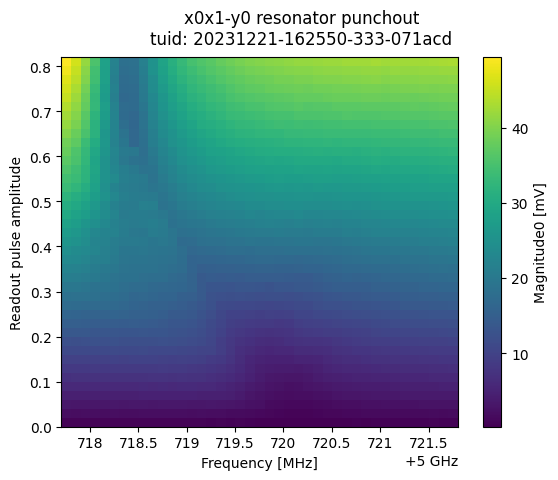

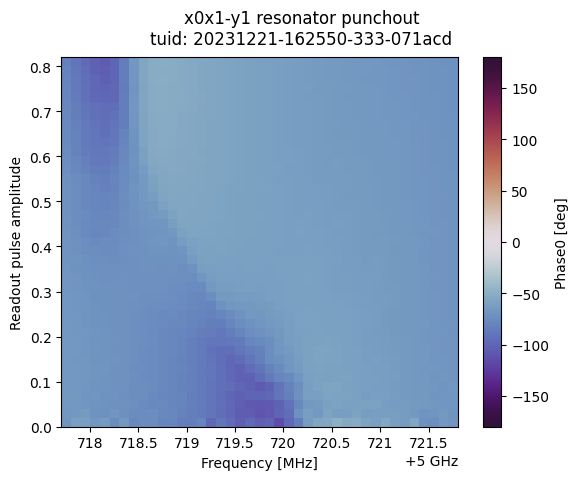

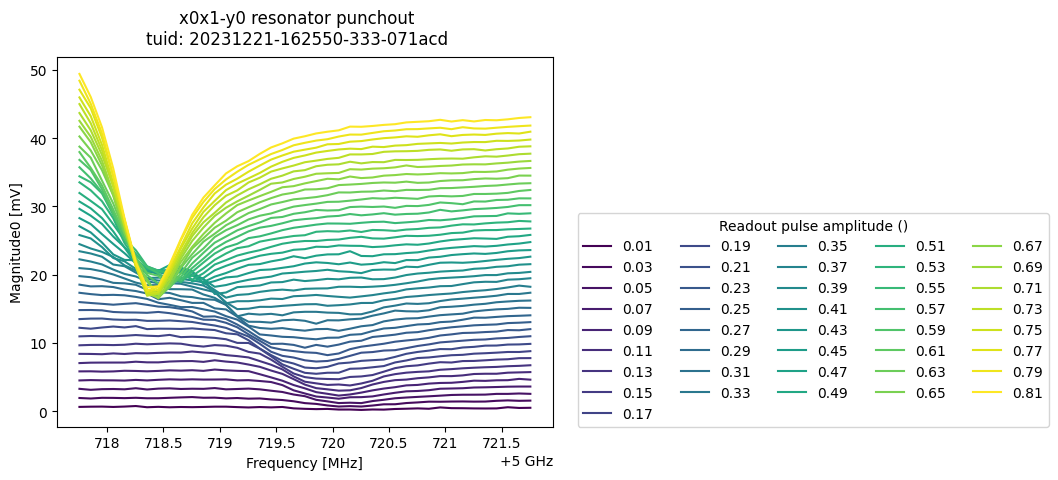

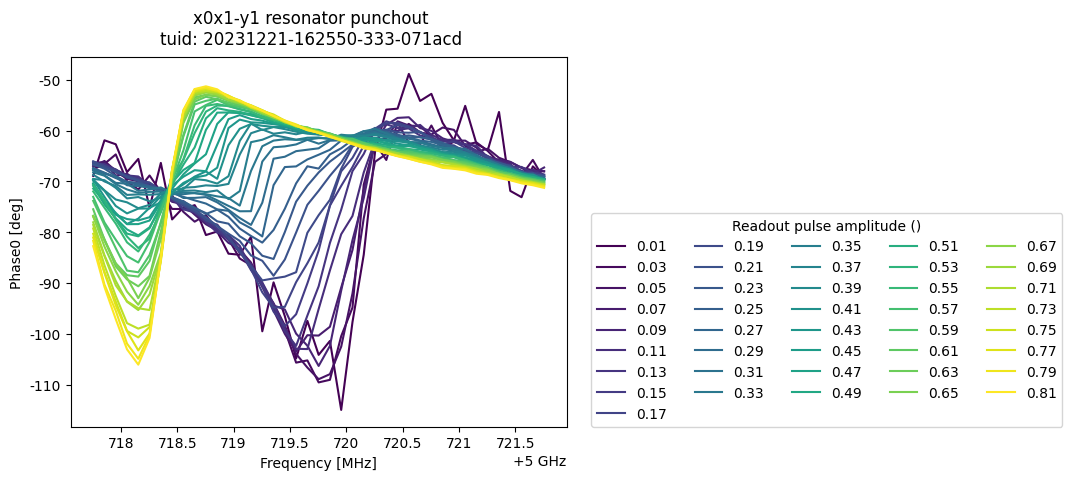

In [88]:

# ============= manually set Parameters =================
repeat_times = 500
rof_center = qubit.clock_freqs.readout()  # Range ~4MHz
rof_span = 2e6
rof_resolutions = 0.1e6
rol_end =  0.8      
rol_resolutions = 0.02
# =======================================================
rof_samples = arange(rof_center-rof_span,rof_center+rof_span+rof_resolutions,rof_resolutions)
rol_samples = arange(0.01,rol_end+rol_resolutions,rol_resolutions)

# declare variables
freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True

ro_pulse_amp = ManualParameter(name="ro_pulse_amp", unit="", label="Readout pulse amplitude")
ro_pulse_amp.batched = False
# Two axis need two ManualParameters

# Requisition
spec_sched_kwargs = dict(
    pulse_amp=ro_pulse_amp,
    pulse_duration=qubit.measure.pulse_duration(),
    frequencies=freq,
    acquisition_delay=qubit.measure.acq_delay(),
    integration_time=qubit.measure.integration_time(),
    init_duration=10e-6, # only cavity shorter is enough
    port=qubit.ports.readout(),
    clock=qubit.name + ".ro",
)
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=heterodyne_spec_sched_nco,
    schedule_kwargs=spec_sched_kwargs,
    real_imag=False,
    batched=True,
)
show_args(spec_sched_kwargs, title="spec_sched_kwargs")

# send the requisition to MeasurementControl-er
quantum_device.cfg_sched_repetitions(repeat_times)
meas_ctrl.gettables(gettable)
meas_ctrl.settables([freq, ro_pulse_amp])
meas_ctrl.setpoints_grid((rof_samples, rol_samples))

# MeasurementControl-er start measurement by the requisition
punchout_ds = meas_ctrl.run("resonator punchout")
punchout_ds

# analysis
b2a = Basic2DAnalysis(tuid=punchout_ds.attrs["tuid"], dataset=punchout_ds)
b2a.run().display_figs_mpl()

# TODO: feedback 

In [89]:
executor = True
if executor:
    qubit.measure.pulse_amp(0.03)
    qubit.clock_freqs.readout(5.71985e9)
    executor = False
show_readout_args(qubit)

qubit.measure
pulse_type                = SquarePulse
pulse_amp                 = 0.03
pulse_duration            = 2e-06
acq_channel               = 8
acq_delay                 = 8e-08
integration_time          = 1.5e-06
reset_clock_phase         = True
acq_weights_a             = None
acq_weights_b             = None
acq_weights_sampling_rate = None
acq_weight_type           = SSB
acq_rotation              = 0
acq_threshold             = 0

qubit.reset
duration = 0.0001

qubit.clock_freqs
readout = 5719850000.0


Flux dependent cavity
---
> Need to set output channel as a parameter

spec_sched_kwargs
pulse_amp         = 0.03
pulse_duration    = 2e-06
frequencies       = freq
acquisition_delay = 8e-08
integration_time  = 1.5e-06
init_duration     = 0.0001
port              = qubit:res
clock             = qubit.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 out0_offset 
Batched settable(s):
	 freq 
Batch size limit: 100



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

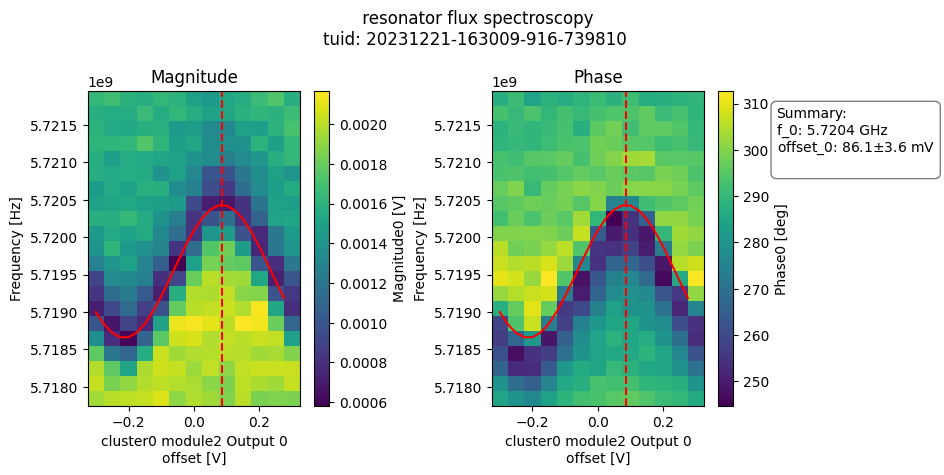

In [90]:

# ============= manually set Parameters =================
repeat_times = 300
rof_center = qubit.clock_freqs.readout()
rof_span = 2e6      # Range ~4MHz
rof_resolutions = 0.2e6
flux_start = -0.3       
flux_stop = 0.3            # unit: volt
flux_resolutions = 0.05
# =======================================================
rof_samples = arange(rof_center-rof_span,rof_center+rof_span+rof_resolutions,rof_resolutions)
bias_samples = arange(flux_start,flux_stop+flux_resolutions,flux_resolutions)

# declare variables
freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True
freq.batch_size = 100

# Requisition
spec_sched_kwargs = dict(
    pulse_amp=qubit.measure.pulse_amp(),
    pulse_duration=qubit.measure.pulse_duration(),
    frequencies=freq,
    acquisition_delay=qubit.measure.acq_delay(),
    integration_time=qubit.measure.integration_time(),
    init_duration=qubit.reset.duration(),
    port=qubit.ports.readout(),
    clock=qubit.name + ".ro",
)
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=heterodyne_spec_sched_nco,
    schedule_kwargs=spec_sched_kwargs,
    real_imag=False,
    batched=True,
)
show_args(spec_sched_kwargs, title="spec_sched_kwargs")

# send the requisition to MeasurementControl-er
quantum_device.cfg_sched_repetitions(repeat_times)
meas_ctrl.gettables(gettable)
meas_ctrl.settables([freq, flux_settable])  # *** Is 'flux_settable' a function in meas_ctrl? Is there any other function that I can use?
meas_ctrl.setpoints_grid((rof_samples, bias_samples))

# MeasurementControl-er start measurement by the requisition
rfs_ds = meas_ctrl.run("resonator flux spectroscopy")
rfs_ds

# analysis
rfs_analysis = ResonatorFluxSpectroscopyAnalysis(tuid=rfs_ds.attrs["tuid"], dataset=rfs_ds)
rfs_analysis.run(fit_method="fast", sweetspot_index=0).display_figs_mpl()

# Feedback
# qubit.clock_freqs.readout(rfs_analysis.quantities_of_interest["freq_0"])
# flux_settable(rfs_analysis.quantities_of_interest["offset_0"].nominal_value)


In [91]:
executor = True
if executor:
    qubit.clock_freqs.readout(rfs_analysis.quantities_of_interest["freq_0"])
    flux_settable(rfs_analysis.quantities_of_interest["offset_0"].nominal_value)
    executor = False
show_readout_args(qubit)

qubit.measure
pulse_type                = SquarePulse
pulse_amp                 = 0.03
pulse_duration            = 2e-06
acq_channel               = 8
acq_delay                 = 8e-08
integration_time          = 1.5e-06
reset_clock_phase         = True
acq_weights_a             = None
acq_weights_b             = None
acq_weights_sampling_rate = None
acq_weight_type           = SSB
acq_rotation              = 0
acq_threshold             = 0

qubit.reset
duration = 0.0001

qubit.clock_freqs
readout = 5720430115.993489


Two-tone
----

> Under construction


qubit_spec_sched_kwargs
qubit_name             = qubit
spec_pulse_amp         = 0.05
spec_pulse_duration    = 4.8e-05
spec_pulse_port        = qubit:mw
spec_pulse_clock       = qubit.01
spec_pulse_frequencies = freq
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 201



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

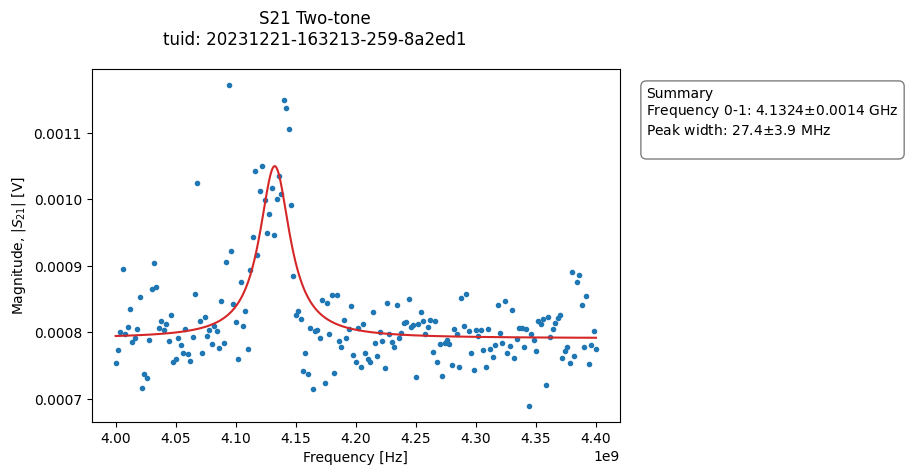

In [95]:

# ============= manually set Parameters =================
repeat_times = 900
meas_freq = qubit.clock_freqs.readout()
xyf_center = 4.2e9
xyf_span = 200e6
xyf_resolutions = 2e6
xyw = 48e-6
# =========================================================
xyf_samples = arange(xyf_center-xyf_span,xyf_center+xyf_span+xyf_resolutions,xyf_resolutions)

# declare the variables
freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True

# Requisition
qubit_spec_sched_kwargs = dict(
    qubit_name=qubit.name,
    spec_pulse_amp=0.05,
    spec_pulse_duration=xyw,
    spec_pulse_port=qubit.ports.microwave(),
    spec_pulse_clock=qubit.name + ".01",
    spec_pulse_frequencies=freq    
)

gettable = ScheduleGettable(
    quantum_device,
    schedule_function=two_tone_spec_sched_nco,
    schedule_kwargs=qubit_spec_sched_kwargs,
    real_imag=False,
    batched=True,
)
show_args(qubit_spec_sched_kwargs, title="qubit_spec_sched_kwargs")

# send the requisition to MeasurementControl-er
quantum_device.cfg_sched_repetitions(repeat_times)
meas_ctrl.gettables(gettable)
meas_ctrl.settables(freq)
meas_ctrl.setpoints(xyf_samples)

# MeasurementControl-er start measurement by the requisition
qs_ds = meas_ctrl.run("Two-tone")
qs_ds

# analysis
qs_analysis = QubitSpectroscopyAnalysis(tuid=qs_ds.attrs["tuid"], dataset=qs_ds)
qs_analysis.run().display_figs_mpl()

# Feedback
# qubit.clock_freqs.f01(qs_analysis.quantities_of_interest['frequency_01'].nominal_value)

In [96]:
executor = True
if executor :
    qubit.clock_freqs.f01(qs_analysis.quantities_of_interest['frequency_01'].nominal_value)
    executor = False
show_drive_args(qubit)

qubit.rxy
amp180   = nan
motzoi   = 0
duration = 2e-08

qubit.clock_freqs
f01 = 4132444697.8466115


## power Rabi oscillation


rabi_sched_kwargs
pulse_amp      = pulse_amplitude
pulse_duration = 2e-08
frequency      = 4132444697.8466115
qubit          = qubit
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 pulse_amplitude 
Batch size limit: 200



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

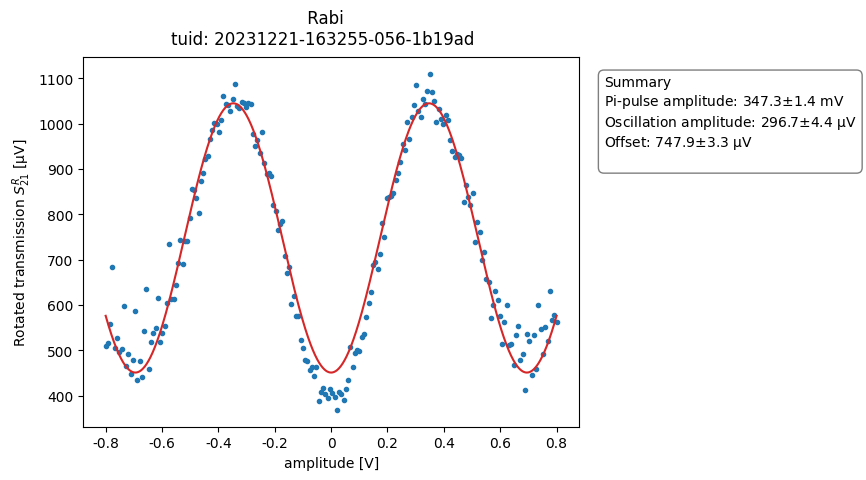

In [97]:

# ============= manually set Parameters =================
repeat_times = 2000
end_XYL = 0.8
fitpoint_num = 200
# ====================================================
xyl_samples = np.linspace(-end_XYL, end_XYL, fitpoint_num)

# declare the variables
ctrl_pulse_amp = ManualParameter(name="pulse_amplitude", unit="V", label="amplitude")
ctrl_pulse_amp.batched = True

# Requisition
rabi_sched_kwargs = {
    "pulse_amp": ctrl_pulse_amp,
    "pulse_duration": qubit.rxy.duration(),
    "frequency": qubit.clock_freqs.f01(),
    "qubit": qubit.name,
}
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=rabi_sched,
    schedule_kwargs=rabi_sched_kwargs,
    batched=True,
)
show_args(rabi_sched_kwargs, title="rabi_sched_kwargs")

# send the requisition to MeasurementControl-er
quantum_device.cfg_sched_repetitions(repeat_times)
meas_ctrl.gettables(gettable)
meas_ctrl.settables(ctrl_pulse_amp)
meas_ctrl.setpoints(xyl_samples)

# MeasurementControl-er start measurement by the requisition
rabi_ds = meas_ctrl.run("Rabi")
rabi_ds

# Analysis
rabi_analysis = RabiAnalysis(tuid=rabi_ds.attrs["tuid"], dataset=rabi_ds)
rabi_analysis.run().display_figs_mpl()

# Feedback
# qubit.rxy.amp180(rabi_analysis.quantities_of_interest["Pi-pulse amplitude"].nominal_value)

In [98]:
executor = True
if executor:
    qubit.rxy.amp180(rabi_analysis.quantities_of_interest["Pi-pulse amplitude"].nominal_value)
    executor = False
show_drive_args(qubit)

qubit.rxy
amp180   = 0.3472733521845951
motzoi   = 0
duration = 2e-08

qubit.clock_freqs
f01 = 4132444697.8466115


## Time Rabi

rabi_sched_kwargs
pulse_amp      = 0.3472733521845951
pulse_duration = pulse_duration
frequency      = 4132444697.8466115
qubit          = qubit
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 pulse_duration 
Batch size limit: 25



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

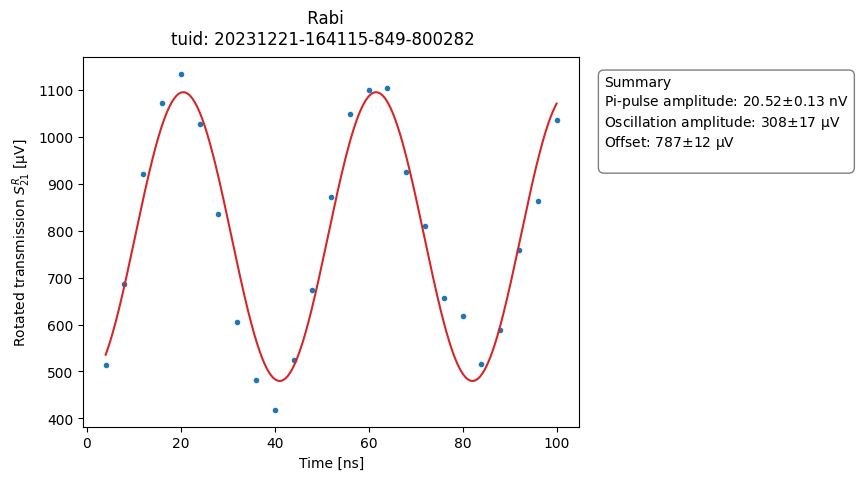

In [105]:
# ============= manually set Parameters =================
repeat_times = 8000
end_xyw = 100e-9
start_xyw = 4e-9
xyw_resolutions = 4e-9
# ====================================================
xyw_samples = arange(start_xyw, end_xyw+xyw_resolutions, xyw_resolutions)

# declare the variables
ctrl_pulse_dura = ManualParameter(name="pulse_duration", unit="s", label="Time")
ctrl_pulse_dura.batched = True

# Requisition
rabi_sched_kwargs = {
    "pulse_amp": qubit.rxy.amp180(),
    "pulse_duration": ctrl_pulse_dura,
    "frequency": qubit.clock_freqs.f01(),
    "qubit": qubit.name,
}
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=rabi_sched,
    schedule_kwargs=rabi_sched_kwargs,
    batched=True,
)
show_args(rabi_sched_kwargs, title="rabi_sched_kwargs")

# send the requisition to MeasurementControl-er
quantum_device.cfg_sched_repetitions(repeat_times)
meas_ctrl.gettables(gettable)
meas_ctrl.settables(ctrl_pulse_dura)
meas_ctrl.setpoints(xyw_samples)

# MeasurementControl-er start measurement by the requisition
rabi_ds = meas_ctrl.run("Rabi")
rabi_ds

# Analysis
rabi_analysis = RabiAnalysis(tuid=rabi_ds.attrs["tuid"], dataset=rabi_ds)
rabi_analysis.run().display_figs_mpl()

# Feedback
# qubit.rxy.amp180(rabi_analysis.quantities_of_interest["Pi-pulse amplitude"].nominal_value)

## Ramsey

ramsey_sched_kwargs
qubit               = qubit
times               = tau
artificial_detuning = 500000.0
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 51



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

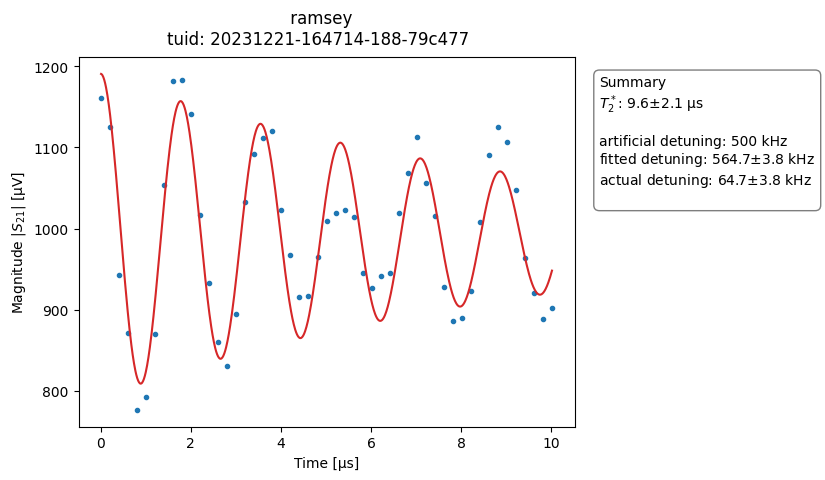

In [111]:

# ============= manually set parameters ===================
repeat_times = 8000
revo_start_time = 12e-9
revo_end_time = 10e-6
virtual_detune = 0.5e6
revo_resolutions = 200e-9
# =========================================================
revo_samples = arange(revo_start_time, revo_end_time+revo_resolutions, revo_resolutions)

# declare variables
tau = ManualParameter(name="tau", unit="s", label="Time")
tau.batched = True

# Requisition
ramsey_sched_kwargs = {
    "qubit": qubit.name,
    "times": tau,
    "artificial_detuning": virtual_detune,
}
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=ramsey_sched,
    schedule_kwargs=ramsey_sched_kwargs,
    real_imag=False,
    batched=True,
)
show_args(ramsey_sched_kwargs, title="ramsey_sched_kwargs")

# send the requisition to MeasurementControl-er
quantum_device.cfg_sched_repetitions(repeat_times)
meas_ctrl.gettables(gettable)
meas_ctrl.settables(tau)
meas_ctrl.setpoints(revo_samples)

# MeasurementControl-er start measurement by the requisition
ramsey_ds = meas_ctrl.run("ramsey")
ramsey_ds

# Analysis
ramsey_analysis = RamseyAnalysis(tuid=ramsey_ds.attrs["tuid"], dataset=ramsey_ds)
ramsey_analysis.run(
    artificial_detuning=ramsey_sched_kwargs["artificial_detuning"]
).display_figs_mpl()

# Feedback
# qubit.clock_freqs.f01(qubit.clock_freqs.f01()+ramsey_analysis.quantities_of_interest['detuning'].nominal_value)

In [108]:
executor = False
if executor:
    qubit.clock_freqs.f01(qubit.clock_freqs.f01()-ramsey_analysis.quantities_of_interest['detuning'].nominal_value)
    executor = False
show_drive_args(qubit)

qubit.rxy
amp180   = 0.3472733521845951
motzoi   = 0
duration = 2e-08

qubit.clock_freqs
f01 = 4126303072.46056


## T1

t1_sched_kwargs
qubit = qubit
times = tau_delay
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

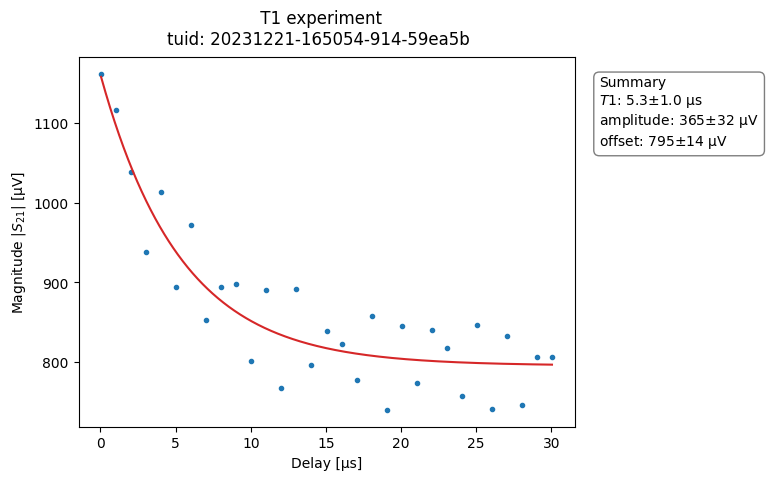

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

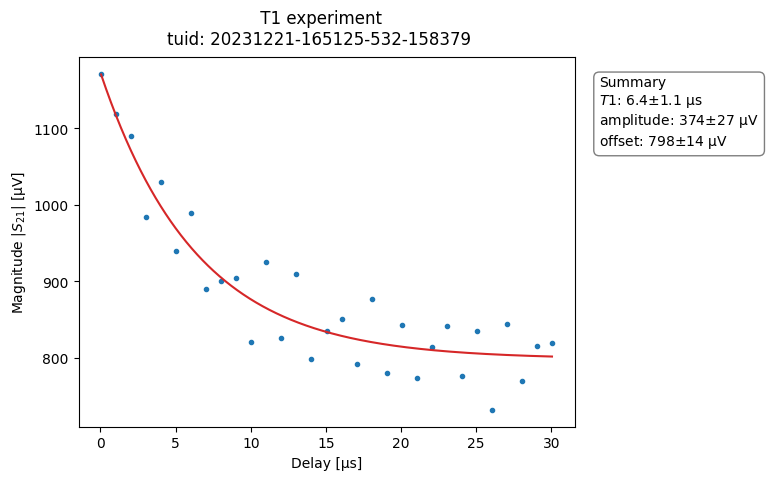

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

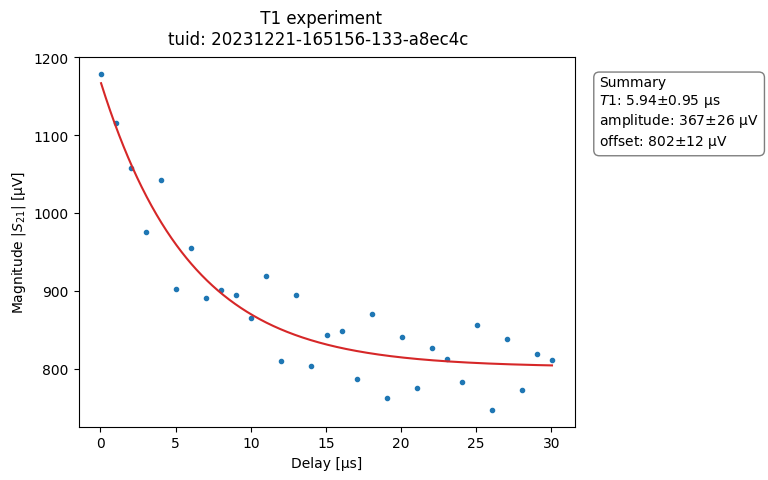

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

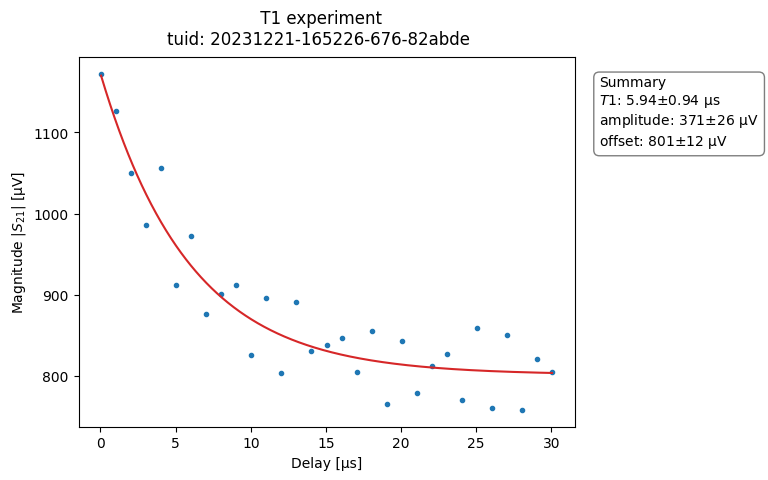

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

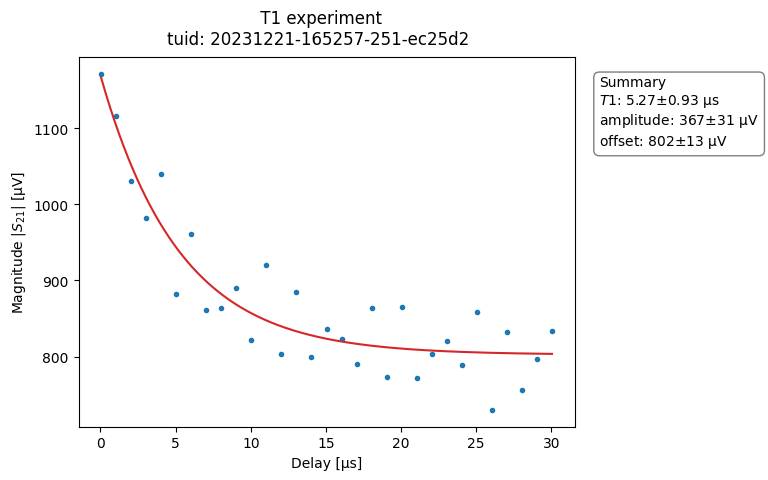

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

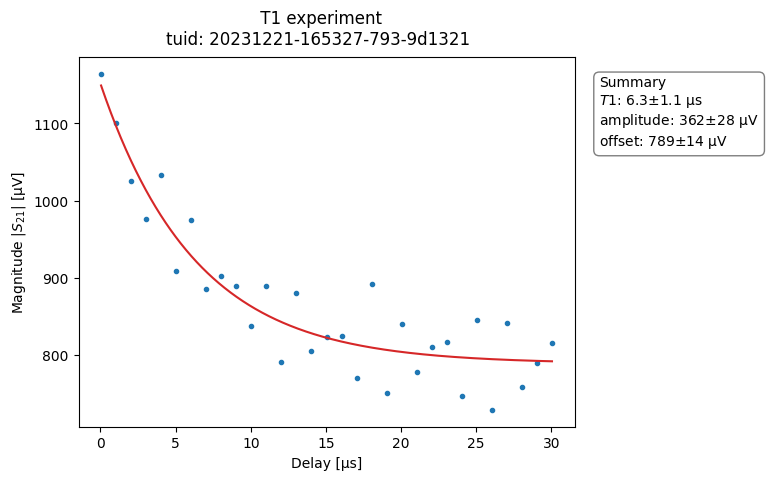

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

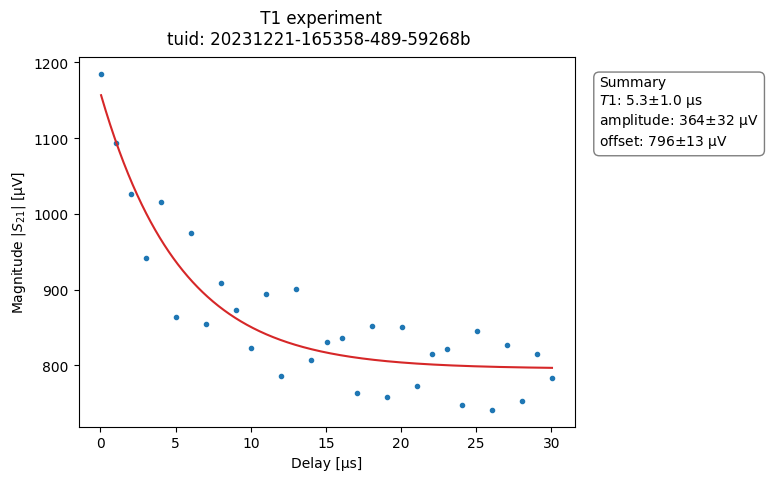

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

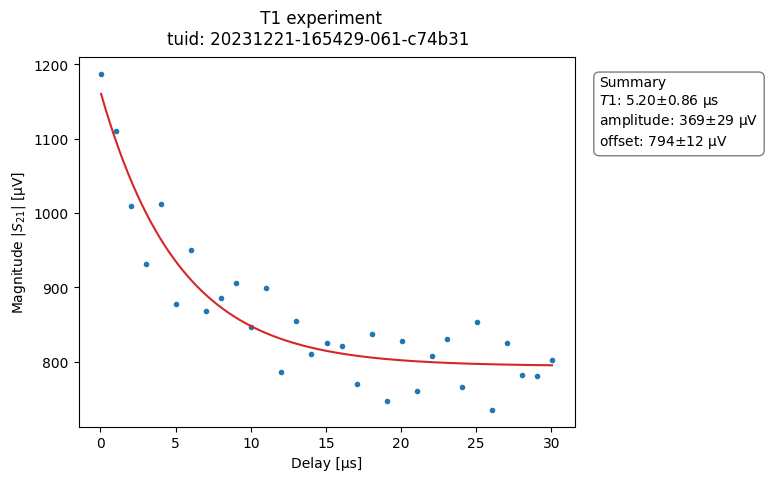

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

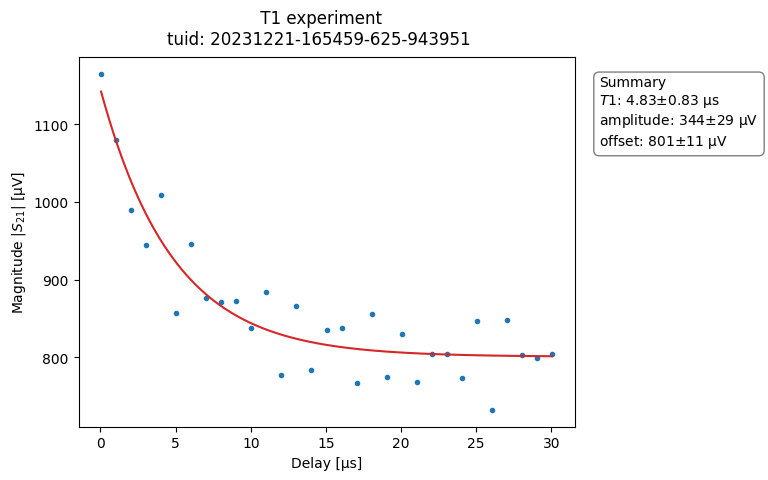

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

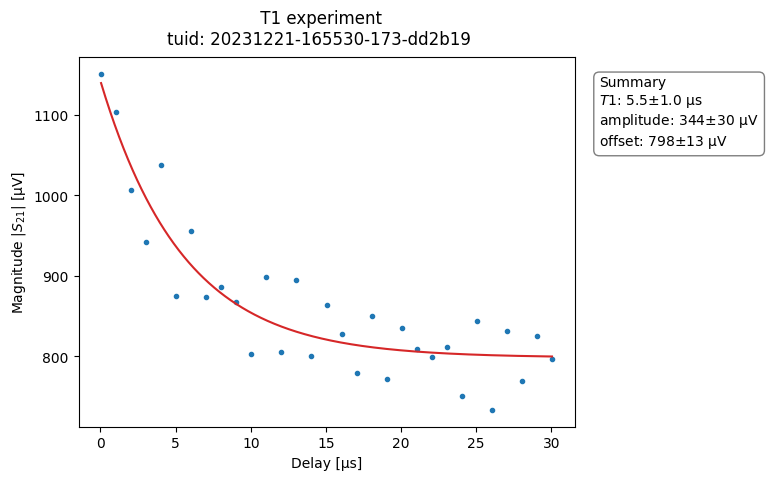

In [115]:

# ============= manually set parameters ===================
repeat_times = 8000
exp_times = 1
relax_start_time = 40e-9
relax_end_time = 30e-6
relax_resolutions = 1e-6
# =========================================================
relax_samples = arange(relax_start_time, relax_end_time+relax_resolutions, relax_resolutions)

# declare variables
tau = ManualParameter(name="tau_delay", unit="s", label="Delay")
tau.batched = True

# Requisition
t1_sched_kwargs = {
    "qubit": qubit.name, 
    "times": tau
}
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=t1_sched,
    schedule_kwargs=t1_sched_kwargs,
    real_imag=False,
    batched=True,
)
show_args(t1_sched_kwargs, title="t1_sched_kwargs")

# send the requisition to MeasurementControl-er
quantum_device.cfg_sched_repetitions(repeat_times)
meas_ctrl.gettables(gettable)
meas_ctrl.settables(tau)
meas_ctrl.setpoints(relax_samples)

# MeasurementControl-er start measurement by the requisition
T1_rec = []
for i in range(exp_times):
    T1_ds = meas_ctrl.run("T1 experiment")
    T1_ds

    # Analysis
    t1_analysis = T1Analysis(tuid=T1_ds.attrs["tuid"], dataset=T1_ds)
    t1_analysis.run().display_figs_mpl()
    T1_rec.append(t1_analysis.quantities_of_interest['T1'].nominal_value)
# Feedback
# T1 = t1_analysis.quantities_of_interest['T1'].nominal_value

In [121]:
from numpy import average, std, array
print(f"T1 ={average(array(T1_rec))} 土 {std(array(T1_rec))}")

T1 =5.605348833559453e-06 土 4.886399318918312e-07


In [122]:
Instrument.close_all()
